## 1. Build Regression Model with TF DenseFeatures

### Overview
- Used preprocessed dataset from TF regression tutorial https://www.tensorflow.org/tutorials/keras/regression
- Used TF feature column API and TF DenseFeatures instead of the methods used in tutorial

### Dataset Preprocessing From Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
#split 80 20 train test split
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [9]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


In [10]:
train_labels = train_dataset['MPG']

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [12]:
categorical_feature_list = ['Origin']
# for the sake of this exercise treat Model Year and Cylinders as numerical but could process differently
numerical_feature_list = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear']

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset[numerical_feature_list])
normed_test_data = norm(test_dataset[numerical_feature_list])

In [14]:
norm_train_data = pd.concat([ train_dataset[categorical_feature_list + ['MPG']],  normed_train_data], 
                            axis=1, sort=False)
norm_test_data = pd.concat([ test_dataset[categorical_feature_list + ['MPG']], normed_test_data], axis=1, sort=False)

In [15]:
norm_train_data.to_csv("mpg_train_data.csv", index=False)
norm_test_data.to_csv("mpg_test_data.csv", index=False)

In [16]:
norm_train_data.head()

,Origin,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear
146,USA,28.0,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,USA,22.3,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,USA,12.0,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,USA,38.0,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,Japan,33.8,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


### Load Preprocessed Dataset

- Use TF Dataset API and Feature Column APIs instead

In [17]:
train_data = pd.read_csv("mpg_train_data.csv" )
test_data = pd.read_csv("mpg_test_data.csv" )

In [18]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [19]:
PREDICTOR_FIELD = 'MPG'
batch_size = 128
train_ds = df_to_dataset(train_data, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_data, PREDICTOR_FIELD, batch_size=batch_size)

In [20]:
sample_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Convert Origin Categorical Feature to One Hot Encoded Feature

In [21]:
# only feature 
v_list = tf.feature_column.categorical_column_with_vocabulary_list("Origin", 
                                                            train_data['Origin'].unique())
one_hot_origin_feature = tf.feature_column.indicator_column(v_list)

In [22]:
print("Example categorical field:\n{}".format(one_hot_origin_feature))
demo(one_hot_origin_feature, sample_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0

### Create Numerical Features

NOTE: We do not use the normalizer function here because the dataset has already been normalized.

In [23]:
#convert numerical features, these features have already been normalized
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(
                    key=c,  dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [24]:
tf_numerical_feature_list = create_tf_numerical_feature_cols(numerical_feature_list)

In [25]:
tf_numerical_feature_list

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [26]:
# take first numerical feature
test_cont_var1 = tf_numerical_feature_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, sample_batch)

Example continuous field:
NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.8693

### Combine TF Features with DenseFeatures

In [27]:
feature_columns = [ one_hot_origin_feature ] + tf_numerical_feature_list

In [28]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [29]:
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [30]:
# Use same architecture as example
def build_model(dense_feature_layer):
    model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    return model

In [31]:
model = build_model(dense_feature_layer)

In [32]:
# validation split

In [33]:
# No validation set b/c need to build separate TF dataset
EPOCHS = 2000
# Set to patience to 100 so it trains to end of epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Train for 3 steps
Epoch 1/2000
3/3 [==============================] - 1s 434ms/step - loss: 573.0601 - mae: 22.7978 - mse: 578.0497
Epoch 2/2000
3/3 [==============================] - 0s 19ms/step - loss: 559.8485 - mae: 22.2097 - mse: 551.7612
Epoch 3/2000
3/3 [==============================] - 0s 18ms/step - loss: 522.7540 - mae: 21.6911 - mse: 529.5777
Epoch 4/2000
3/3 [==============================] - 0s 16ms/step - loss: 512.7932 - mae: 21.1907 - mse: 508.3134
Epoch 5/2000
3/3 [==============================] - 0s 19ms/step - loss: 480.3592 - mae: 20.6586 - mse: 486.3640
Epoch 6/2000
3/3 [==============================] - 0s 20ms/step - loss: 457.6406 - mae: 20.1033 - mse: 463.8869
Epoch 7/2000
3/3 [==============================] - 0s 20ms/step - loss: 434.8696 - mae: 19.5183 - mse: 440.3844
Epoch 8/2000
3/3 [==============================] - 0s 19ms/step - loss: 416.9980 - mae: 18.8978 - mse: 415.9779
Epoch 9/2000
3/3 [==============================] - 0s 21ms/step - loss: 389.

3/3 [==============================] - 0s 19ms/step - loss: 6.4806 - mae: 1.7734 - mse: 6.2302
Epoch 148/2000
3/3 [==============================] - 0s 19ms/step - loss: 6.6800 - mae: 1.8281 - mse: 6.5510
Epoch 149/2000
3/3 [==============================] - 0s 18ms/step - loss: 6.5428 - mae: 1.7819 - mse: 6.2365
Epoch 150/2000
3/3 [==============================] - 0s 16ms/step - loss: 5.9600 - mae: 1.7797 - mse: 6.3218
Epoch 151/2000
3/3 [==============================] - 0s 20ms/step - loss: 6.1657 - mae: 1.7647 - mse: 6.1585
Epoch 152/2000
3/3 [==============================] - 0s 19ms/step - loss: 6.2251 - mae: 1.7578 - mse: 6.1446
Epoch 153/2000
3/3 [==============================] - 0s 19ms/step - loss: 6.0590 - mae: 1.7902 - mse: 6.2544
Epoch 154/2000
3/3 [==============================] - 0s 18ms/step - loss: 5.9763 - mae: 1.7539 - mse: 6.1839
Epoch 155/2000
3/3 [==============================] - 0s 20ms/step - loss: 5.9750 - mae: 1.7920 - mse: 6.2273
Epoch 156/2000
3/3 [=====

In [34]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 5.7788 - mae: 1.9173 - mse: 5.7788


In [35]:
test_labels = test_data[PREDICTOR_FIELD].values

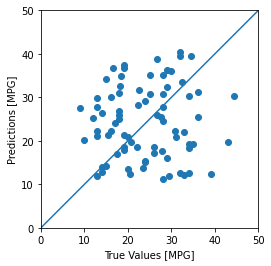

In [36]:
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


### Show Model Prediction Output

In [37]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [38]:
model_output_df.head()

,pred,actual_value
0,14.097097,15.0
1,20.138439,10.0
2,27.565411,9.0
3,30.834457,25.0
4,18.492266,19.0


## 2. Model Evaluation 

### Preparing Regression Output for Binary Scoring Model Evaluation

- Create binary label for mileage prediction over 25 miles per gallon
    - 0 = Not Fuel Efficient, < 25 MPG
    - 1 = Fuel Efficient >= 25 MPG

In [39]:
# Convert Regression Output to binary classification output
model_output_df.head()

,pred,actual_value
0,14.097097,15.0
1,20.138439,10.0
2,27.565411,9.0
3,30.834457,25.0
4,18.492266,19.0


In [40]:
def convert_to_binary(df, pred_field, actual_field):
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=25 else 0 )
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=25 else 0)
    return df

In [41]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,14.097097,15.0,0,0
1,20.138439,10.0,0,0
2,27.565411,9.0,1,0
3,30.834457,25.0,1,1
4,18.492266,19.0,0,0


### Classification Common Model Evaluation Metrics

In [42]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [43]:
print(classification_report(binary_df['label_value'], binary_df['score']))

              precision    recall  f1-score   support

           0       0.55      0.54      0.54        41
           1       0.50      0.51      0.51        37

    accuracy                           0.53        78
   macro avg       0.53      0.53      0.52        78
weighted avg       0.53      0.53      0.53        78



In [44]:
#F1
f1_score(binary_df['label_value'], binary_df['score'], average='weighted')

0.525875276986388

In [45]:
#AUC - area under the ROC curve
roc_auc_score(binary_df['label_value'], binary_df['score'])

0.5250494396835861

### Brier Score

In [46]:
random_predictions = np.random.random((100))
random_predictions

array([0.42328984, 0.93998179, 0.67487863, 0.28705188, 0.20387247,
       0.03497271, 0.57396341, 0.63800654, 0.30302418, 0.32178687,
       0.75315119, 0.02399315, 0.80912235, 0.93710987, 0.31799915,
       0.09809318, 0.34921136, 0.92783895, 0.66036108, 0.42217091,
       0.60205585, 0.34707321, 0.75810743, 0.50027767, 0.28522992,
       0.1516203 , 0.02700134, 0.74692527, 0.45331779, 0.10824616,
       0.24812032, 0.270686  , 0.76094576, 0.5939485 , 0.25540138,
       0.7420461 , 0.07858137, 0.32507146, 0.26931093, 0.02373897,
       0.9809954 , 0.98953802, 0.12174467, 0.90554973, 0.86137336,
       0.46347025, 0.0452363 , 0.44791037, 0.87158238, 0.09046718,
       0.56340129, 0.96423786, 0.49243831, 0.80385467, 0.9186825 ,
       0.98800004, 0.42459355, 0.53209903, 0.46903294, 0.85981347,
       0.99369758, 0.41147073, 0.74018255, 0.07791441, 0.38699105,
       0.50150941, 0.59018187, 0.66222196, 0.83152891, 0.22683609,
       0.42850408, 0.29655032, 0.56098698, 0.95276686, 0.51233

In [47]:
random_labels = np.random.choice([0, 1], 100)
random_labels

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1])

- Convert probability to binary predictions

In [48]:
probability_prediction_df = pd.DataFrame({"prob_prediction": random_predictions,
                "binary_prediction": np.array([ 1 if abs(x)>=0.5 else 0 for x in random_predictions], dtype=int),
                                "label": random_labels})

In [49]:
probability_prediction_df.head()

,prob_prediction,binary_prediction,label
0,0.423290,0,1
1,0.939982,1,1
2,0.674879,1,1
3,0.287052,0,0
4,0.203872,0,0


In [50]:
y_true = probability_prediction_df['label'].values 
y_pred = probability_prediction_df['binary_prediction'].values

In [51]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.51


In [52]:
bs_loss = brier_score_loss(y_true, probability_prediction_df['prob_prediction'])
print(bs_loss)

0.3300255120477705


### Misclassified

In [53]:
missclassified_df = probability_prediction_df[probability_prediction_df['binary_prediction']!=probability_prediction_df['label']]

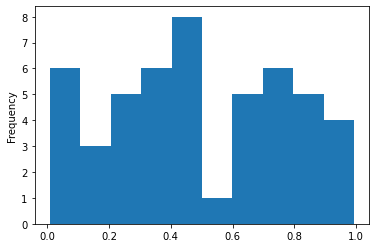

In [54]:
missclassified_df['prob_prediction'].plot(kind='hist')

## 3. Demographic Group Bias Analysis

- Select groups to analyze
- Prepare data 
- Analyze groups


### Select groups to analyze
- Selected 'origin' field which gives the country of origin for the car.

In [55]:
#combine binary df with original test df, order was not shuffled so can do

In [56]:
merged_binary_df = binary_df.assign(origin = test_data['Origin'].values)

In [57]:
merged_binary_df.head()

,pred,actual_value,score,label_value,origin
0,14.097097,15.0,0,0,USA
1,20.138439,10.0,0,0,USA
2,27.565411,9.0,1,0,USA
3,30.834457,25.0,1,1,Japan
4,18.492266,19.0,0,0,USA


### Prepare Data

In [58]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [59]:
ae_df, _ = preprocess_input_df(merged_binary_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [38]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


### Analyze Groups

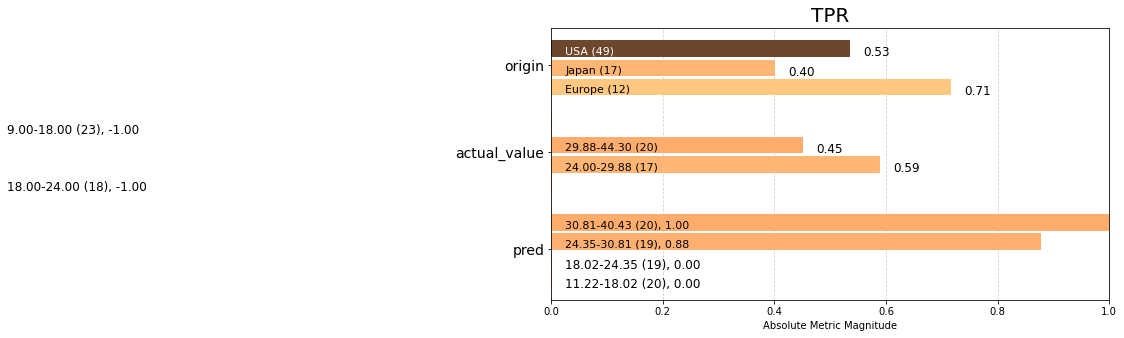

In [60]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

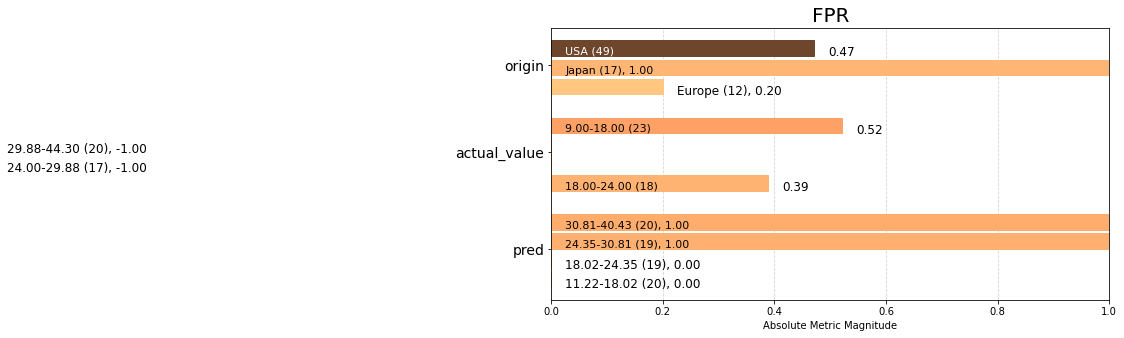

In [61]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

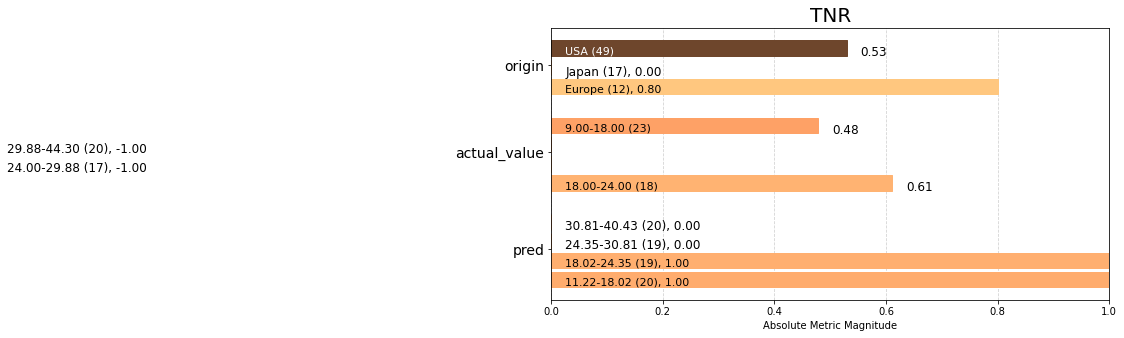

In [62]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

In [63]:
# Bias Report - http://aequitas.dssg.io/audit/eg1cp7ku/adult_rf_binary/

## 4. Train Uncertainty Estimation Model with TF Probability

### Instructions
- Using MPG model from earlier, create uncertainty estimation model with TF Probability.
- In particular, we will focus on building a model that accounts for Aleatoric Uncertainty.

In [64]:
import tensorflow_probability as tfp

### Aleatoric Uncertainty
- Known Unknowns
- 2 Main Changes to our network 
    - Add a second unit to the last dense layer before passing it to Tensorflow Probability layer to model for the predictor y and the heteroscedasticity or unequal scattering of data
    - DistributionLambda distribution mean and std
- DistributionLambda is a special Keras layer that uses a Python lambda to construct a distribution based on the layer inputs and the output of the final layer of the model is passed into the loss function. Lastly. this model will return a distribution for both mean and standard deviation.

In [65]:
train_label_stats = train_labels.describe()
train_label_stats

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [66]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(  
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])

            )
         )
  
        
        
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

### Train Probability Model

In [67]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=500)

Train for 3 steps
Epoch 1/500
3/3 [==============================] - 1s 401ms/step - loss: 264.1360 - mse: 423.7832
Epoch 2/500
3/3 [==============================] - 0s 19ms/step - loss: 13.2878 - mse: 2814.7373
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 13.5796 - mse: 13313.3232
Epoch 4/500
3/3 [==============================] - 0s 20ms/step - loss: 9.2853 - mse: 21073.1680
Epoch 5/500
3/3 [==============================] - 0s 21ms/step - loss: 6.7000 - mse: 18843.5430
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 5.7569 - mse: 13744.018 - 0s 20ms/step - loss: 5.5697 - mse: 12330.3379
Epoch 7/500
3/3 [==============================] - 0s 18ms/step - loss: 5.3362 - mse: 8739.8818
Epoch 8/500
3/3 [==============================] - 0s 17ms/step - loss: 5.4714 - mse: 11058.6279
Epoch 9/500
3/3 [==============================] - 0s 20ms/step - loss: 5.7090 - mse: 16360.6875
Epoch 10/500
3/3 [==============================] - 0s 20ms/step -

3/3 [==============================] - 0s 21ms/step - loss: 2.2677 - mse: 19.4018
Epoch 167/500
3/3 [==============================] - 0s 21ms/step - loss: 2.2555 - mse: 15.3802
Epoch 168/500
3/3 [==============================] - 0s 22ms/step - loss: 2.1963 - mse: 14.3329
Epoch 169/500
3/3 [==============================] - 0s 20ms/step - loss: 2.2003 - mse: 17.0232
Epoch 170/500
3/3 [==============================] - 0s 22ms/step - loss: 2.1421 - mse: 14.8855
Epoch 171/500
3/3 [==============================] - 0s 20ms/step - loss: 2.1170 - mse: 11.7457
Epoch 172/500
3/3 [==============================] - 0s 20ms/step - loss: 2.1356 - mse: 13.6389
Epoch 173/500
3/3 [==============================] - 0s 21ms/step - loss: 2.1136 - mse: 11.4087
Epoch 174/500
3/3 [==============================] - 0s 19ms/step - loss: 2.1110 - mse: 12.5198
Epoch 175/500
3/3 [==============================] - 0s 20ms/step - loss: 2.0788 - mse: 12.0364
Epoch 176/500
3/3 [==============================] - 0

Epoch 335/500
3/3 [==============================] - 0s 18ms/step - loss: 1.9610 - mse: 8.3895
Epoch 336/500
3/3 [==============================] - 0s 18ms/step - loss: 1.8676 - mse: 7.5259
Epoch 337/500
3/3 [==============================] - 0s 20ms/step - loss: 1.8457 - mse: 7.2017
Epoch 338/500
3/3 [==============================] - 0s 18ms/step - loss: 1.8158 - mse: 7.6600
Epoch 339/500
3/3 [==============================] - 0s 20ms/step - loss: 1.8038 - mse: 8.5696
Epoch 340/500
3/3 [==============================] - 0s 19ms/step - loss: 1.7473 - mse: 8.5496
Epoch 341/500
3/3 [==============================] - 0s 19ms/step - loss: 1.7857 - mse: 8.5856
Epoch 342/500
3/3 [==============================] - 0s 19ms/step - loss: 1.7831 - mse: 8.2030
Epoch 343/500
3/3 [==============================] - 0s 20ms/step - loss: 1.7973 - mse: 8.6886
Epoch 344/500
3/3 [==============================] - 0s 19ms/step - loss: 1.8091 - mse: 8.4455
Epoch 345/500
3/3 [==============================]

### Extract Mean and Standard Deviation Output

In [68]:
feature_column_list = categorical_feature_list + numerical_feature_list
x_tst = dict(test_data[feature_column_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [69]:
m[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[14.103442],
       [10.78768 ],
       [ 9.502421],
       [25.406609],
       [21.768501],
       [13.729074],
       [13.873668],
       [13.149668],
       [22.520145],
       [31.632454]], dtype=float32)>

In [70]:
s[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.780095  ],
       [0.73915607],
       [0.7356695 ],
       [1.3563879 ],
       [1.0450312 ],
       [0.7143916 ],
       [0.71395856],
       [0.71179795],
       [0.9317029 ],
       [1.9829581 ]], dtype=float32)>

In [71]:
prob_outputs = {
    "pred": prob_preds.flatten(),
    "actual_value": test_data['MPG'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [72]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,33.733738,15.0,14.103442,0.780095
1,22.035141,10.0,10.787680,0.739156
2,14.674532,9.0,9.502421,0.735669
3,30.422451,25.0,25.406609,1.356388
4,19.943218,19.0,21.768501,1.045031


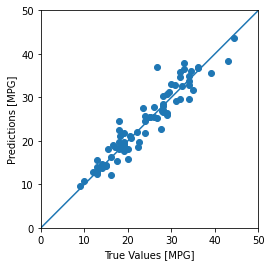

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 5. Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [74]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [75]:
import shap
shap.initjs()

### Train Model without Dense Features

In [76]:
def build_shap_model( num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [77]:
shap_num_features = len( numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
#shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model( shap_num_features)

In [78]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit( normed_train_data, train_labels,  callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Train on 314 samples
Epoch 1/1000
314/314 [==============================] - 1s 3ms/sample - loss: 568.7803 - mae: 22.5863 - mse: 568.7803
Epoch 2/1000
314/314 [==============================] - 0s 150us/sample - loss: 513.2391 - mae: 21.3306 - mse: 513.2391
Epoch 3/1000
314/314 [==============================] - 0s 129us/sample - loss: 457.1290 - mae: 19.9881 - mse: 457.1291
Epoch 4/1000
314/314 [==============================] - 0s 124us/sample - loss: 394.5816 - mae: 18.3705 - mse: 394.5816
Epoch 5/1000
314/314 [==============================] - 0s 151us/sample - loss: 327.2939 - mae: 16.5433 - mse: 327.2939
Epoch 6/1000
314/314 [==============================] - 0s 115us/sample - loss: 259.2712 - mae: 14.5766 - mse: 259.2712
Epoch 7/1000
314/314 [==============================] - 0s 143us/sample - loss: 195.1192 - mae: 12.5906 - mse: 195.1192
Epoch 8/1000
314/314 [==============================] - 0s 128us/sample - loss: 137.6571 - mae: 10.5339 - mse: 137.6571
Epoch 9/1000
314/314 

### Use KMeans to Summarize Dataset

In [79]:
df_train_normed_summary = shap.kmeans(normed_train_data.values, 25)


In [80]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(shap_model.predict, df_train_normed_summary)

In [81]:
# `ipywidgets` may need to be installed to see status visualization.
# Please uncomment these two lines:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# And restart the kernel and run the notebook after installing the ipwidgets.
# From the top menu, click `Kernel` -> `Restart & Run All`

Defaulting to user installation because normal site-packages is not writeable
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [82]:
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(normed_train_data.values)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


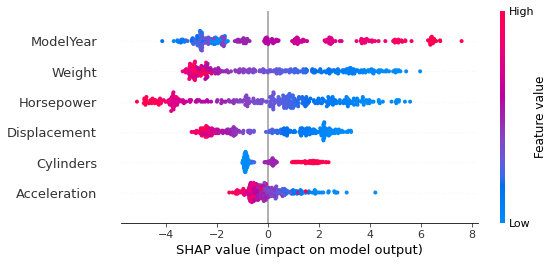

In [83]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], normed_train_data)

In [84]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], normed_train_data.iloc[INSTANCE_NUM,:])

In [85]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], normed_train_data.iloc[0:NUM_ROWS])